# ISOMAP

##### 패키지 불러오기

In [30]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
import os
import warnings
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra

from matplotlib.pyplot import style
from multiprocessing import Pool
import itertools
warnings.filterwarnings('ignore')
from sklearn.manifold import Isomap

random.seed(9697)
np.random.seed(9697)


##### MNIST 데이터셋 불러오기
##### 전체 데이터셋 중 1/30만 사용했음

In [3]:
mnist = fetch_openml('mnist_784')
df = mnist.data
df['target'] =mnist.target 
data = mnist.data[::30]
target = mnist.target[::30]

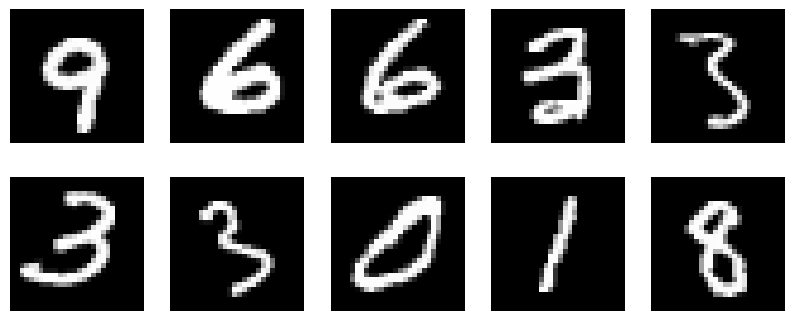

In [4]:
# 0~69999 숫자 중 랜덤으로 10개 선별(인덱스 기준)
random_idx = np.random.choice(70000, 10)

# 흰색 배경 및 크기 지정
style.use('default')
figure = plt.figure()
figure.set_size_inches(10, 4)

# 시각화를 위한 target column 제외
columns_list = list(df.columns)
columns_list.remove('target')

# 흑백으로 출력하기 위한 스타일 설정
style.use('grayscale')

# 2 * 5 사이즈의 격자 설정
axes = []
for i in range(1, 11):
    axes.append(figure.add_subplot(2, 5, i))

num_list = []
for i in range(10):
    num = df.loc[random_idx[i], columns_list] # 랜덤으로 선별된 인덱스 위치에 해당하는 픽셀 정보 가져오기
    num = np.array(num).reshape(-1, 28).astype(int) # 픽셀값을 28 * 28 사이즈로 바꾸고 정수형 변환 진행
    num_list.append(num)

for i in range(10):
    axes[i].matshow(num_list[i]) # 10개 숫자 차례대로 시각화
    axes[i].set_axis_off() # x축, y축 눈금 제거

##### K-NN 기반 거리행렬과 MDS, ISOMAP 구현

In [4]:
def construct_knn_distance_matrix(X: np.array, k: int=5):
    pairwise_distances = cdist(X, X, 'euclidean')
    knn_indices = pairwise_distances.argsort()[:, :k+1]
    row_indices = np.repeat(np.array(range(0, X.shape[0]*X.shape[0], X.shape[0])), repeats=k+1)

    graph_distances = np.zeros((X.shape[0], X.shape[0]), dtype=float)
    
    flat_indices = knn_indices.reshape(-1) + row_indices
    flat_vals = np.take(pairwise_distances.reshape(-1), flat_indices, 0)
    np.put(graph_distances.reshape(-1), flat_indices, flat_vals)
    graph_distances = graph_distances.reshape(X.shape[0], -1)
    graph_distances = (graph_distances + graph_distances.T)/2
    graph_distances = np.where(graph_distances <= 0, 1e3, graph_distances)
    np.fill_diagonal(graph_distances, 0.0)
    assert (graph_distances == graph_distances.T).all()
    return graph_distances

def dijkstra_distances(distance_matrix):
    graph = csr_matrix(distance_matrix)
    dist_matrix = dijkstra(csgraph=graph)
    return distance_matrix

def multidimensional_scaling(distance_matrix: np.array):
    assert distance_matrix.shape[0] == distance_matrix.shape[1]
    
    n = distance_matrix.shape[0]
    
    A = -0.5 * np.power(distance_matrix, 2)
    H = np.identity(n) - np.ones((n, n), dtype=float)/n
    B = H @ A @ H
    
    p = np.linalg.matrix_rank(B)
    e_lambda, e_v= np.linalg.eig(B)
    
    X = e_v[:, :p] @ np.diag(np.sqrt(e_lambda[:p]))
    return X

def ISOMAP(X: np.array, k: int=5):
    knn_distance_matrix = construct_knn_distance_matrix(X, k)
    dijkstra_distance_matrix = dijkstra_distances(knn_distance_matrix)
    X_prime = multidimensional_scaling(dijkstra_distance_matrix)
    return X_prime

In [11]:
data[data.columns] = StandardScaler().fit_transform(data[data.columns].values)
coordinate_matrix = ISOMAP(data[data.columns].values, k=20)
coordinates = coordinate_matrix[:,:2]

##### K-NN 기반 ISOMAP을 기반으로 시각화하기

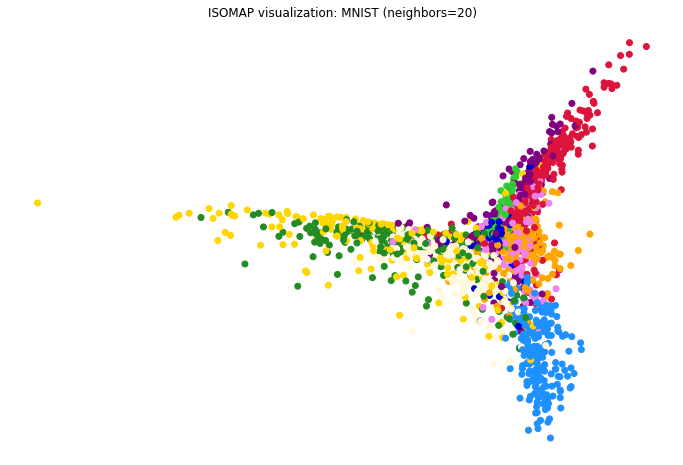

In [37]:
scaffold_colors = ['purple', 'crimson', 'forestgreen', 'mediumblue', 'orange',
                   'limegreen', 'violet', 'dodgerblue', 'gold', 'cornsilk']
plt.figure(figsize=(12, 8))
colors = [scaffold_colors[idx] for idx in pd.factorize(target)[0]]
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors)
plt.title("ISOMAP visualization: MNIST (neighbors=20)")
plt.axis('off')
plt.show()

##### Sklearn 패키기를 사용했을때와 비교

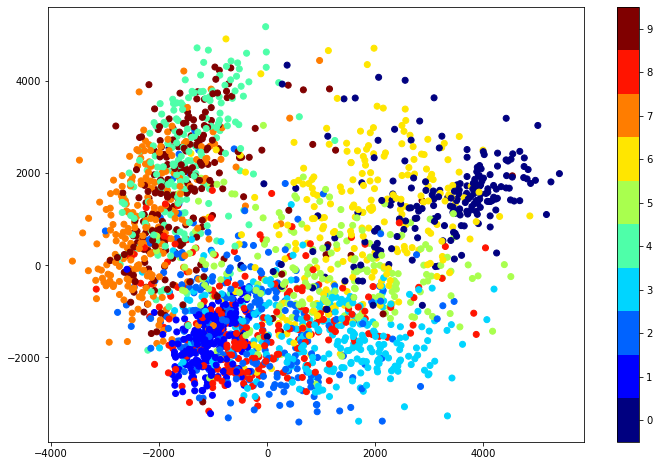

In [40]:
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2, n_neighbors=20)
proj = model.fit_transform(data)
plt.figure(figsize=(12, 8))
plt.scatter(proj[:, 0], proj[:, 1], c=target.astype(int), 
            cmap=plt.cm.get_cmap('jet', 10)) # need to convert target into int
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);